# Invariant Risk Minimization

Exploration of the paper https://arxiv.org/pdf/1907.02893v2.pdf

Pytorch code: https://github.com/facebookresearch/InvariantRiskMinimization/


## 0) Dataset exploration/setup

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, Multiply
from keras.layers import Conv2D, MaxPooling2D, Conv3D, MaxPool3D
from keras import backend as K
import numpy as np

Using TensorFlow backend.


In [30]:
import random

In [3]:
import tensorflow as tf

In [4]:
from sklearn.metrics import accuracy_score, log_loss

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
    
# convert to RGB
x_train = np.stack((x_train,)*3, axis=-1)
x_test = np.stack((x_test,)*3, axis=-1)

# normalize
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# binary label
y_train = (y_train < 5).astype(int)
y_test = (y_test < 5).astype(int)

11493376/11490434 [==============================] - 1s 0us/step


(60000, 28, 28, 3)

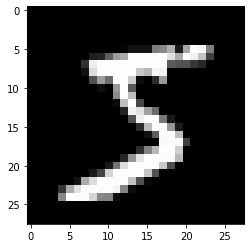

In [6]:
plt.imshow(x_train[0])
x_train.shape

(60000, 28, 28, 3)

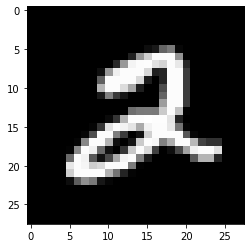

In [7]:
plt.imshow(x_train[5])
x_train.shape

In [8]:
def get_env(x, y, e, labelflip_proba=.25):
    x = x.copy()
    y = y.copy()
    
    y = np.logical_xor(
        y,
        (np.random.random(size=len(y)) < labelflip_proba).astype(int)
    ).astype(int)
    
    color = np.logical_xor(
        y,
        (np.random.random(size=len(y)) < e).astype(int)
    )
    
    x[color, :, :, 2] = 0
    x[color, :, :, 1] = 0
    return x, y

In [9]:
x, y = get_env(x_train, y_train, .5)

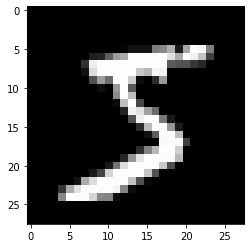

In [10]:
plt.imshow(x[0])

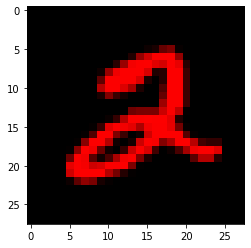

In [11]:
plt.imshow(x[5])

In [12]:
def get_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(28, 28, 3)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy', 'crossentropy'])
    return model

In [13]:
get_model().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)               

### 0.2) check model is good for the initial task (greyscale + no label flip)

In [14]:
get_model().fit(*get_env(x_train, y_train, 0),
                batch_size=128,
                epochs=1,
                verbose=1,
                validation_data=get_env(x_test, y_test, 0))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 13s 209us/step - loss: 0.0098 - accuracy: 0.9959 - crossentropy: 0.0098 - val_loss: 9.9567e-07 - val_accuracy: 1.0000 - val_crossentropy: 9.9567e-07


### 0.3) our 3 envs

In [15]:
e1 = get_env(x_train[:10000], y_train[:10000], .1)
e2 = get_env(x_train[10000:20000], y_train[10000:20000], .2)
e3 = get_env(x_train[20000:30000], y_train[20000:30000], .9)

## 1) Claim: ERM in separate envs are fooled

In [16]:
get_model().fit(*e1,
                batch_size=128,
                epochs=5,
                verbose=1,
                validation_data=e3)

Train on 10000 samples, validate on 10000 samples
Epoch 1/5
10000/10000 [==============================] - 3s 256us/step - loss: 0.3809 - accuracy: 0.8827 - crossentropy: 0.3809 - val_loss: 1.9649 - val_accuracy: 0.0957 - val_crossentropy: 1.9649
Epoch 2/5
10000/10000 [==============================] - 2s 240us/step - loss: 0.3392 - accuracy: 0.8996 - crossentropy: 0.3392 - val_loss: 1.7764 - val_accuracy: 0.0957 - val_crossentropy: 1.7764
Epoch 3/5
10000/10000 [==============================] - 2s 229us/step - loss: 0.3300 - accuracy: 0.8998 - crossentropy: 0.3300 - val_loss: 1.7693 - val_accuracy: 0.0961 - val_crossentropy: 1.7693
Epoch 4/5
10000/10000 [==============================] - 2s 231us/step - loss: 0.3191 - accuracy: 0.8999 - crossentropy: 0.3191 - val_loss: 1.6670 - val_accuracy: 0.1075 - val_crossentropy: 1.6670
Epoch 5/5
10000/10000 [==============================] - 2s 232us/step - loss: 0.3176 - accuracy: 0.8998 - crossentropy: 0.3176 - val_loss: 1.5179 - val_accuracy:

In [17]:
get_model().fit(*e2,
                batch_size=128,
                epochs=5,
                verbose=1,
                validation_data=e3)

Train on 10000 samples, validate on 10000 samples
Epoch 1/5
10000/10000 [==============================] - 3s 254us/step - loss: 0.5339 - accuracy: 0.7781 - crossentropy: 0.5339 - val_loss: 1.2771 - val_accuracy: 0.1232 - val_crossentropy: 1.2771
Epoch 2/5
10000/10000 [==============================] - 2s 230us/step - loss: 0.4979 - accuracy: 0.7919 - crossentropy: 0.4979 - val_loss: 1.3912 - val_accuracy: 0.1009 - val_crossentropy: 1.3912
Epoch 3/5
10000/10000 [==============================] - 2s 231us/step - loss: 0.4774 - accuracy: 0.7925 - crossentropy: 0.4774 - val_loss: 1.0916 - val_accuracy: 0.3035 - val_crossentropy: 1.0916
Epoch 4/5
10000/10000 [==============================] - 2s 229us/step - loss: 0.4657 - accuracy: 0.7917 - crossentropy: 0.4657 - val_loss: 1.5232 - val_accuracy: 0.1373 - val_crossentropy: 1.5232
Epoch 5/5
10000/10000 [==============================] - 2s 238us/step - loss: 0.4640 - accuracy: 0.7950 - crossentropy: 0.4640 - val_loss: 1.3337 - val_accuracy:

## 2) Claim: ERM on merged envs is fooled too

In [18]:
e12 = (np.vstack([e1[0], e2[0]]), np.hstack([e1[1], e2[1]]))

In [19]:
get_model().fit(*e12,
                batch_size=128,
                epochs=5,
                verbose=1,
                validation_data=e3)

Train on 20000 samples, validate on 10000 samples
Epoch 1/5
20000/20000 [==============================] - 5s 225us/step - loss: 0.4547 - accuracy: 0.8372 - crossentropy: 0.4547 - val_loss: 1.8169 - val_accuracy: 0.0957 - val_crossentropy: 1.8169
Epoch 2/5
20000/20000 [==============================] - 4s 210us/step - loss: 0.4150 - accuracy: 0.8468 - crossentropy: 0.4150 - val_loss: 1.1267 - val_accuracy: 0.0962 - val_crossentropy: 1.1267
Epoch 3/5
20000/20000 [==============================] - 4s 207us/step - loss: 0.4030 - accuracy: 0.8469 - crossentropy: 0.4030 - val_loss: 1.4850 - val_accuracy: 0.1054 - val_crossentropy: 1.4850
Epoch 4/5
20000/20000 [==============================] - 4s 211us/step - loss: 0.3966 - accuracy: 0.8462 - crossentropy: 0.3966 - val_loss: 1.4074 - val_accuracy: 0.1528 - val_crossentropy: 1.4074
Epoch 5/5
20000/20000 [==============================] - 4s 207us/step - loss: 0.3906 - accuracy: 0.8469 - crossentropy: 0.3906 - val_loss: 1.4231 - val_accuracy:

## 3) Claim: Robust ERM will be fooled too

robust objective: $f = argmin_f \{ max_e R^e(f) - var(Y^e) \}$

In [20]:
e1_loss = .3263
e2_loss = .4570
e1_var = e1[1].var()
e2_var = e2[1].var()
print(e1_loss, e1_var, e1_loss - e1_var)
print(e2_loss, e2_var, e2_loss - e2_var)

0.3263 0.24992603999999996 0.07637396000000002
0.457 0.24998479000000007 0.20701520999999995


### 3.1) jittering implem of robust objective

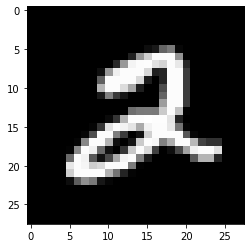

In [21]:
plt.imshow(x_train[5])

In [22]:
def jitter_color(x, scale=.25):
    x_jit = x.copy()
    for channel in (2,): #range(3):
        mask = x_jit[:,:,channel] > 0
        x_jit[:,:,channel] += mask * (np.random.normal(scale=scale, size=(28,28)))**2
        if x_jit[:,:,channel].max() > 1.:
            x_jit[:,:,channel] /= x_jit[:,:,channel].max()
    return x_jit

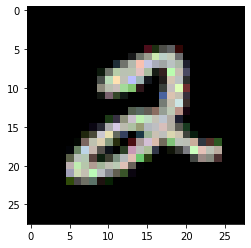

In [23]:
x_jit = jitter_color(x_train[5])
plt.imshow(x_jit)

In [24]:
for j in range(10):
    e12_jit = np.array([jitter_color(xx, scale=.5) for xx in e12[0]])
    m = get_model()
    m.fit(e12_jit, e12[1],
          batch_size=128,
          epochs=3,
          verbose=0)
    y_pred_train_jit = (m.predict(e12_jit)[:,0] > .5).astype(int)
    y_pred_train = (m.predict(e12[0])[:,0] > .5).astype(int)
    y_pred_ood = (m.predict(e3[0])[:,0] > .5).astype(int)
    print("train_acc_jit", accuracy_score(e12[1], y_pred_train_jit), 
          "train_acc", accuracy_score(e12[1], y_pred_train), 
          "ood_acc", accuracy_score(e3[1], y_pred_ood))

train_acc_jit 0.84785 train_acc 0.84755 ood_acc 0.101
train_acc_jit 0.8483 train_acc 0.84485 ood_acc 0.1141
train_acc_jit 0.84855 train_acc 0.84215 ood_acc 0.1239
train_acc_jit 0.84075 train_acc 0.84785 ood_acc 0.0992
train_acc_jit 0.8331 train_acc 0.8463 ood_acc 0.1142
train_acc_jit 0.84835 train_acc 0.84845 ood_acc 0.0957
train_acc_jit 0.8482 train_acc 0.84825 ood_acc 0.0968
train_acc_jit 0.8484 train_acc 0.8484 ood_acc 0.0972
train_acc_jit 0.84815 train_acc 0.8485 ood_acc 0.0957
train_acc_jit 0.84835 train_acc 0.847 ood_acc 0.1031


## Domain Adaptation: merged ERM with constraint on distrib_dist({phi(X^e)}_e=1..n)

### Adverserial Domain Adaptation
http://openaccess.thecvf.com/content_cvpr_2017/papers/Tzeng_Adversarial_Discriminative_Domain_CVPR_2017_paper.pdf

In [205]:
class MixedEnvDataGenerator(keras.utils.Sequence):
    
    def __init__(self, adv_weight=.05, e1_weight=1.0, e2_weight=1.0, batch_size=128, shuffle=True):
        
        self.__load_initial_data()
        self.__create_envs()
        self.__create_validation_envs()

        self.batch_size = batch_size
        self.halfbatch_size = int(np.floor(batch_size/2))
        self.e1_weight = e1_weight
        self.e2_weight = e2_weight
        self.adv_weight = adv_weight
        self.shuffle = shuffle
        self.indices = np.arange(len(self.e1[1]))
        print(len(self), 'batches/epoch')
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.e1[1]) / self.halfbatch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        
        halfbatch_indices = self.indices[index*self.halfbatch_size:(index+1)*self.halfbatch_size]
        
        e1_x_batch = self.e1[0][halfbatch_indices,:,:,:]
        e2_x_batch = self.e2[0][halfbatch_indices,:,:,:]
        e1_y_batch = self.e1[1][halfbatch_indices]
        e2_y_batch = self.e2[1][halfbatch_indices]
        
        mixed_x = np.vstack([
            e1_x_batch,
            e2_x_batch,
        ])
        
        e1_y = np.hstack([e1_y_batch, np.zeros(self.halfbatch_size)])
        e1_w = self.e1_weight * np.hstack([np.ones(self.halfbatch_size), np.zeros(self.halfbatch_size)])
        
        e2_y = np.hstack([np.zeros(self.halfbatch_size), e2_y_batch])
        e2_w = self.e2_weight * np.hstack([np.zeros(self.halfbatch_size), np.ones(self.halfbatch_size)])
        
        adv_y = np.hstack([np.ones(self.halfbatch_size), np.zeros(self.halfbatch_size)])
        adv_w = self.adv_weight * np.ones(len(adv_y))
        
        return [
            mixed_x,
            [e1_y, e2_y, adv_y],
            [e1_w, e2_w, adv_w]
        ]
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.e1[1]))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __load_initial_data(self):
        (x_train, y_train), (x_test, y_test) = mnist.load_data()

        # convert to RGB
        x_train = np.stack((x_train,)*3, axis=-1)
        x_test = np.stack((x_test,)*3, axis=-1)

        # normalize
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train /= 255
        x_test /= 255

        # binary label
        y_train = (y_train < 5).astype(int)
        y_test = (y_test < 5).astype(int)
        
        self.original_data = {
            'x_train':x_train,
            'x_test':x_test,
            'y_train':y_train,
            'y_test':y_test
        }
        
    def __create_envs(self):
        self.e1 = self.__create_env(self.original_data['x_train'][:10000], 
                                    self.original_data['y_train'][:10000], .1)
        self.e2 = self.__create_env(self.original_data['x_train'][10000:20000], 
                                    self.original_data['y_train'][10000:20000], .2)
        self.e3 = self.__create_env(self.original_data['x_train'][20000:30000], 
                                    self.original_data['y_train'][20000:30000], .9)
        
    def __create_validation_envs(self):
        self.e11 = self.__create_env(self.original_data['x_train'][30000:40000], 
                                     self.original_data['y_train'][30000:40000], .1)
        self.e22 = self.__create_env(self.original_data['x_train'][40000:50000], 
                                     self.original_data['y_train'][40000:50000], .2)
        self.e33 = self.__create_env(self.original_data['x_train'][50000:60000], 
                                     self.original_data['y_train'][50000:60000], .9)
        half_len = int(len(self.e11[1])/2)
        self.eaa = [
            np.vstack([self.e11[0][:half_len], self.e22[0][:half_len]]),
            np.hstack([np.ones(half_len), np.zeros(half_len)])
        ]
    
    def __create_env(self, x, y, e, labelflip_proba=.25):
        x = x.copy()
        y = y.copy()

        y = np.logical_xor(
            y,
            (np.random.random(size=len(y)) < labelflip_proba).astype(int)
        ).astype(int)

        color = np.logical_xor(
            y,
            (np.random.random(size=len(y)) < e).astype(int)
        )

        x[color, :, :, 2] = 0
        x[color, :, :, 1] = 0
        return x, y

In [189]:
def get_ada_mixed_model():
    
    input_images = Input(shape=(28, 28, 3))
    
    cnn = Conv2D(32, kernel_size=(3, 3),
                 activation='relu')(input_images)
    cnn = Conv2D(64, (3, 3), activation='relu')(cnn)
    cnn = MaxPooling2D(pool_size=(2, 2))(cnn)
    cnn = Dropout(0.25)(cnn)
    cnn = Flatten()(cnn)
    
    env1 = Dense(32, activation='relu')(cnn)
    env1 = Dropout(0.5)(env1)
    env1 = Dense(1, activation='sigmoid', name='env1')(env1)
    
    env2 = Dense(32, activation='relu')(cnn)
    env2 = Dropout(0.5)(env2)
    env2 = Dense(1, activation='sigmoid', name='env2')(env2)
        
    adv = Dense(32, activation='relu')(cnn)
    adv = Dropout(0.5)(adv)
    adv = Dense(1, activation='sigmoid', name='adv')(adv)
    
    model = Model(
        inputs=[input_images],
        outputs=[env1, env2, adv]
    )
    
    def adv_loss(y_true, y_pred):
        return - keras.losses.binary_crossentropy(y_true, y_pred)
    
    model.compile(
        loss=[
            keras.losses.binary_crossentropy,
            keras.losses.binary_crossentropy,
            adv_loss
        ],
        optimizer=keras.optimizers.Adadelta(),
        metrics=['accuracy']
    )
    return model

In [211]:
from collections import defaultdict

In [ ]:
m = get_ada_mixed_model()
g = MixedEnvDataGenerator(adv_weight=5e-4, e1_weight=1, e2_weight=1, shuffle=True)
logs = defaultdict(list)
for _ in range(100):
    m.fit_generator(
        g,
        epochs=5,
        verbose=0,
    )
    print('%3d |'%_, end='')
    (
        loss_all, 
        e1_loss, e2_loss, adv_loss,
        e1_acc, e2_acc, e3_acc
    ) = m.evaluate(g.e11[0], [g.e11[1],g.e11[1],g.e11[1]], verbose=0)
    logs['e11acc'] += [e1_acc]
    logs['e11loss'] += [e1_loss]
    print('e1->e11 acc: %.3f'%e1_acc, end=' | ')
    (
        loss_all, 
        e1_loss, e2_loss, adv_loss,
        e1_acc, e2_acc, e3_acc
    ) = m.evaluate(g.e22[0], [g.e22[1],g.e22[1],g.e22[1]], verbose=0)
    logs['e22acc'] += [e2_acc]
    logs['e22loss'] += [e2_loss]
    print('e2->e22 acc: %.3f'%e2_acc, end=' | ')
    (
        loss_all, 
        e1_loss, e2_loss, adv_loss,
        e1_acc, e2_acc, adv_acc
    ) = m.evaluate(g.eaa[0], [g.eaa[1],g.eaa[1],g.eaa[1]], verbose=0)
    logs['eaaacc'] += [adv_acc]
    logs['eaaloss'] += [adv_loss]
    print('e_a->eaa acc: %.3f'%adv_acc, end=' | ')
    (
        loss_all, 
        e1_loss, e2_loss, adv_loss,
        e1_acc, e2_acc, e3_acc
    ) = m.evaluate(g.e3[0], [g.e3[1], g.e3[1], g.e3[1]], verbose=0)
    logs['e1_33acc'] += [e1_acc]
    logs['e1_33loss'] += [e1_loss]
    logs['e2_33acc'] += [e2_acc]
    logs['e2_33loss'] += [e2_loss]
    print('e1->e3 acc: %.3f'%e1_acc, 'e2->e3 acc: %.3f'%e2_acc)
        

156 batches/epoch
  0 |e1->e11 acc: 0.901 | e2->e22 acc: 0.801 | e_a->eaa acc: 0.501 | e1->e3 acc: 0.101 e2->e3 acc: 0.141
  1 |e1->e11 acc: 0.900 | e2->e22 acc: 0.798 | e_a->eaa acc: 0.501 | e1->e3 acc: 0.104 e2->e3 acc: 0.155
  2 |e1->e11 acc: 0.900 | e2->e22 acc: 0.788 | e_a->eaa acc: 0.500 | e1->e3 acc: 0.108 e2->e3 acc: 0.257
  3 |e1->e11 acc: 0.897 | e2->e22 acc: 0.792 | e_a->eaa acc: 0.500 | e1->e3 acc: 0.119 e2->e3 acc: 0.266
  4 |e1->e11 acc: 0.894 | e2->e22 acc: 0.794 | e_a->eaa acc: 0.500 | e1->e3 acc: 0.123 e2->e3 acc: 0.257
  5 |e1->e11 acc: 0.890 | e2->e22 acc: 0.789 | e_a->eaa acc: 0.500 | e1->e3 acc: 0.145 e2->e3 acc: 0.276
  6 |e1->e11 acc: 0.888 | e2->e22 acc: 0.786 | e_a->eaa acc: 0.500 | e1->e3 acc: 0.162 e2->e3 acc: 0.307
  7 |e1->e11 acc: 0.502 | e2->e22 acc: 0.512 | e_a->eaa acc: 0.500 | e1->e3 acc: 0.508 e2->e3 acc: 0.508
  8 |e1->e11 acc: 0.501 | e2->e22 acc: 0.512 | e_a->eaa acc: 0.500 | e1->e3 acc: 0.508 e2->e3 acc: 0.508
  9 |e1->e11 acc: 0.501 | e2->e22 acc

In [ ]:
for k in ('e11acc','e22acc','eaaacc','e1_33acc','e2_33acc'):
    plt.plot(logs[k[:-3]+'loss'], label=k[:-3]+'loss')
plt.legend(loc='center left')
plt.grid()
plt.yscale('symlog')

In [ ]:
for k in ('e11acc','e22acc','eaaacc','e1_33acc','e2_33acc'):
    plt.plot(logs[k], label=k)
plt.legend(loc='center left')
plt.grid()

## TODO IRM

In [192]:
if True:
        
    input_images = Input(shape=(28, 28, 3))
    
    cnn = Conv2D(32, kernel_size=(3, 3),
                 activation='relu')(input_images)
    cnn = Conv2D(64, (3, 3), activation='relu')(cnn)
    cnn = MaxPooling2D(pool_size=(2, 2))(cnn)
    cnn = Dropout(0.25)(cnn)
    cnn = Flatten()(cnn)
    
    spe = Dense(32, activation='relu')(cnn)
    spe = Dropout(0.5)(spe)
    
    # IRM part
    
    w1 = np.zeros(32)
    w1[0] = 1    
    irm = Dense(1, activation='sigmoid', name='env', 
                bias_initializer=keras.initializers.Zeros(),
                kernel_initializer=keras.initializers.Constant(value=w1),
                use_bias=False,
                trainable=False)(spe)
    irm_model = Model(
        inputs=[input_images],
        outputs=[irm]
    )
    
    class IRMLoss(object):
        def __init__(self, lambda_=1):
            self.lambda_=lambda_
            self.dummy_grad_norm = 0
            self.loss = 1
            self.accuracy = 0
            self.penalty = 1
            
        def update(self, model, x, y):
            
            self.loss, self.accuracy = model.evaluate(x,y,verbose=0)

            output_tensors = model.optimizer.get_gradients(model.total_loss, model.layers[-1].weights[0])
            input_tensors = model.inputs + model.sample_weights + model.targets + [K.learning_phase()]
            get_gradients = K.function(inputs=input_tensors, outputs=output_tensors)
            inputs = [x, np.ones(len(y)), y, 0]
            grads = get_gradients(inputs)
            self.dummy_grad_norm = np.sqrt(np.sum([_**2 for _ in grads[0]]))
            
            self.penalty = np.sum([self.loss * _**2 for _ in grads[0]])
            
        def __call__(self, y_true, y_pred, sample_weight=None):
            loss = keras.losses.binary_crossentropy(y_true, y_pred) + self.lambda_ * self.penalty
            #if loss > 1:
            #    return loss / self.lambda_
            return loss
    
    irm_loss = IRMLoss()
    
    irm_model.compile(
        loss=keras.losses.binary_crossentropy,
        optimizer=keras.optimizers.Adadelta(),
        metrics=['accuracy']
    )    
    
    if True:
        baseline = Dense(1, activation='sigmoid', name='base', 
                         use_bias=False,
                         trainable=True)(spe)
        baseline_model = Model(
            inputs=input_images,
            outputs=baseline
        )
        baseline_model.compile(
            loss=irm_loss,
            optimizer=keras.optimizers.Adadelta(),
            metrics=['accuracy']
        )


In [189]:
irm_loss.lambda_*irm_loss.penalty

1

In [196]:
step_size = 1000#int(len(e1[1])/10)
print("Step size:", step_size)

n_pr = 1

for epoch in range(5,15):
    
    print('-'*80)
    print('Epoch', epoch)
    print('-'*80)
    
    for batch in range(int(len(e1[1])/step_size)-1):
        irm_loss.lambda_ = 0#epoch*10000
        if not batch % n_pr: print("lam: %6d" % irm_loss.lambda_, end=' ')
        for env in (e1, e2):
            x = env[0][batch*step_size:(batch+1)*step_size,:,:,:]
            y = env[1][batch*step_size:(batch+1)*step_size]

            irm_loss.update(irm_model, x, y)
            if not batch % n_pr:
                print("| pen:", '%.3f'%irm_loss.penalty, end=' ')
                loss, acc = baseline_model.evaluate(env[0], env[1], verbose=0)
                print("loss:", '%.3f'%loss, "acc:",'%.3f'%acc, end=' ')

            baseline_model.fit(x=x, y=y, batch_size=step_size, epochs=1, shuffle=True, verbose=0)

        if not batch % n_pr:
            loss, acc = baseline_model.evaluate(e3[0],e3[1],verbose=0)
            print("| e3loss:", '%.3f'%loss, "e3acc:", '%.3f'%acc)

for env in (e1, e2, e3):
    loss, acc = baseline_model.evaluate(env[0], env[1], verbose=0)
    print("| e3loss:", '%.3f'%loss, "e3acc:", '%.3f'%acc)

Step size: 1000
--------------------------------------------------------------------------------
Epoch 5
--------------------------------------------------------------------------------
lam:      0 | pen: 0.185 loss: 1.309 acc: 0.899 | pen: 0.116 loss: 1.482 acc: 0.799 | e3loss: 2.245 e3acc: 0.108
lam:      0 | pen: 0.060 loss: 1.350 acc: 0.897 | pen: 0.130 loss: 1.459 acc: 0.799 | e3loss: 2.261 e3acc: 0.113
lam:      0 | pen: 0.117 loss: 1.342 acc: 0.896 | pen: 0.187 loss: 1.471 acc: 0.799 | e3loss: 2.205 e3acc: 0.100
lam:      0 

KeyboardInterrupt: 